In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from fast_tsne import fast_tsne
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

from Modules import rnaseqTools
from Modules import file_navigation
from Modules import map_to_embeddings

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [4]:
def get_color_dataframe():
    fname = 'References/marker_ref.txt'
    params = {'sep':'\t', 'header':0, 'index_col':0}
    df = pd.read_csv(fname, **params)
    
    return df

def add_ordering_legends(ax, column='Morph-PV-types', labels=[], marker='o', legend_args={}):
    ax.set_xticks([]), ax.set_yticks([])
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    df = df.loc[df.Age>20]
    if len(labels) == 0:
        labels = df[column]
        labels = np.unique(labels[~labels.isna()])
    
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    
    colors = df_marker.loc[labels, 'Face'].values
    
    args = ([0], [0])
    kwargs = {'marker':marker, 'markeredgewidth':.25, 'markersize':4, 'color':'w'}
    patches = [Line2D(*args, label=label,
                      markerfacecolor=df_marker.loc[label, 'Face'],
                      markeredgecolor=df_marker.loc[label, 'Edge'],
                      **kwargs
                     ) for label in labels]
    
    kwargs = {'fontsize':6,
              'ncol':5,
              'loc':'upper center',
              'columnspacing':.9,
              'handletextpad':.5
             }
    kwargs.update(legend_args)
    legend = ax.legend(patches, labels, **kwargs)
    
    return

def do_feature_selection(df, filename='Pvalb_Kobak_Lin'):
    fname = 'Mapping/MarkerGenes/%s.txt' % filename
    with open(fname) as f:
        importantGenes = [line.split()[0] for line in f]
        df = df.loc[:,df.columns.isin(importantGenes)].copy()
    return df

def do_preliminary_reduction(df, normalize=False):
    df = np.log2(1+df)
    if normalize:
        datalist = StandardScaler().fit_transform(df.values)
        df = pd.DataFrame(datalist, index=df.index, columns=df.columns)
    df = do_feature_selection(df)
    
    pca = PCA(n_components=50)
    datalist = pca.fit_transform(df.values)
    df_pca = pd.DataFrame(datalist, index=df.index)
    
    return df_pca

def perform_embeddings(df, perplexity=10, normalize=False, trim=True):
    if trim:
        df_pca = do_preliminary_reduction(df, normalize=normalize)
    else:
        df_pca = df
        if normalize:
            datalist = StandardScaler().fit_transform(df_pca.values)
            df_pca = pd.DataFrame(datalist, index=df_pca.index, columns=df_pca.columns)
    
    columns = ['PCA_X', 'PCA_Y',
               't-SNE_X', 't-SNE_Y',
               'FIt-SNE_X', 'FIt-SNE_Y',
               'UMAP_X', 'UMAP_Y']
    df_embedding = pd.DataFrame(np.NaN, index=df_pca.index, columns=columns)
    
    pca = PCA(n_components=2)
    columns = ['PCA_X', 'PCA_Y']
    df_embedding[columns] = pca.fit_transform(df_pca)
    
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    columns = ['t-SNE_X', 't-SNE_Y']
    df_embedding[columns] = tsne.fit_transform(df_pca)
    
    reducer = umap.UMAP(n_components=2, n_neighbors=perplexity, min_dist=.01, random_state=42, metric='euclidean')
    columns = ['UMAP_X', 'UMAP_Y']
    df_embedding[columns] = reducer.fit_transform(df_pca)
    
    datalist = fast_tsne(df_pca.values, perplexity = perplexity,
                            learning_rate = df_pca.shape[0]/12, knn_algo='vp-tree', seed=42)
    columns = ['FIt-SNE_X', 'FIt-SNE_Y']
    df_embedding[columns] = datalist    
    
    return df_embedding

def get_embeddings():
    fname = 'Mapping/Embeddings/Lab_Pvalb-tpm.tsv'
    params = {'sep':'\t', 'header':0, 'index_col':0}
    df_embedding_tpm = pd.read_csv(fname, **params)
    
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    df_labels = pd.read_csv(fname, na_values='Other', **params)
    
    return df_embedding_tpm, df_labels

def generate_axes(fig, col, method):
    width = .121
    height = .0935
    left = .1775 + .131 * col
    
    axes = []
    for row in range(5):
        ax = fig.add_axes([left, .788 - .13 * row, width, height])
        
        ax.set_xticks([]), ax.set_yticks([])
        if row == 0:
            ax.set_title(method, fontsize=10)
        axes.append(ax)
    
    return axes

def create_series_color_dict(labels):
    labels = list(set(labels))
    values = np.linspace(0,1,len(labels))
    colors = [(value,value,value) for value in values]
    color_dict = {label:color for label, color in zip(labels, colors)}
    #color_dict = {label:(np.random.rand(), np.random.rand(), np.random.rand()) for label in set(labels)}
    
    return color_dict

def add_series_markers(marker_dict, labels):
    labels = list(set(labels))
    markers = ['v', '^', '>', '<', 'o', '*', '|', '-']
    marker_dict.update({label:marker for label, marker in zip(labels, markers)})
    
    return

def generate_color_dict(df_labels):
    color_dict = create_series_color_dict(df_labels.MorphType)
    color_dict.update(create_series_color_dict(df_labels.Mapping))
    color_dict.update(create_series_color_dict(df_labels.proMMT_all))
    color_dict.update(create_series_color_dict(df_labels.proMMT_old))
    
    return color_dict

def expand_marker_dict(marker_dict, df_labels):
    add_series_markers(marker_dict, df_labels.MorphType)
    add_series_markers(marker_dict, df_labels.Mapping)
    add_series_markers(marker_dict, df_labels.proMMT_all)
    add_series_markers(marker_dict, df_labels.proMMT_old)
    
    return

def plot_embeddings(axes, df_labels, df_plot, df_color, add_label=False):
    methods = ['Morphology-PV-types',
               'Mapping-PV-types',
               'proMMT-PV-types',
               'Gender-PV-types',
               'Hemisphere-PV-types'
              ]
    for ax, method in zip(axes, methods):
        df_meta = df_labels.loc[~df_labels[method].isna(), [method]]
        labels = df_meta[method]
        plotlist = df_plot.loc[df_meta.index,:].values
        
        for label in set(labels):
            inds = labels==label
            if label in df_color.index:
                edge, face, marker = df_color.loc[label, ['Edge', 'Face', 'Marker']]
            else:
                edge, face, marker = 'cyan', 'cyan', 'x'
            params = {'facecolor':face,
                      's':16,
                      'edgecolor':edge,
                      'linewidth':.25,
                      'marker':marker,
                     }
            ax.scatter(plotlist[inds,0], plotlist[inds,1], **params)
        
        if add_label:
            ax.set_ylabel(method.split('-PV-')[0], fontsize=10)
    
    return

def add_legend(ax, df_labels, df_color):
    ax.set_xticks([]), ax.set_yticks([])
    for method, labels in df_labels.iteritems():
        
        labels = labels[~labels.isna()]
        
        for label in sorted(set(labels)):
            edge, face, marker = df_color.loc[label, ['Edge', 'Face', 'Marker']]
            ax.scatter([], [], facecolor=face, edgecolor=edge, marker=marker, s=16, label=label, linewidth=.25)
    
    ax.legend(scatterpoints=1, frameon=False, labelspacing=0.2, ncol=7, fontsize=7, loc='center')
    
    return

def generate_axes_legends(fig, df_labels, df_color):
    label_columns = ['Morphology-PV-types',
                     'Mapping-PV-types',
                     'proMMT-PV-types',
                     'Gender-PV-types',
                     'Hemisphere-PV-types',
                     'Morphology-PV-types'
                    ]
    df_labels = df_labels[label_columns]
    
    for row, (method, labels) in enumerate(df_labels.iteritems()):
        if row < 5:
            ax = fig.add_axes([.18, .7665 - row * .13, .64, .015])
        else:
            ax = fig.add_axes([.2, .10, .60, .015])
        ax.set_xticks([]), ax.set_yticks([])
        
        text = method.split('-PV-')[0] + '-based:'
        kwargs = {'ha':'left', 'va':'center', 'transform':ax.transAxes, 'fontsize':8}
        ax.text(.01, .5, text, **kwargs)
        
        labels = labels[~labels.isna()]
        if method == 'Morphology-PV-types':
            labels = ['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC']
        else:
            labels = np.unique(labels)
        
        for label in labels:
            edge, face, marker = df_color.loc[label, ['Edge', 'Face', 'Marker']]
            if label.startswith('Continent'):
                label = {'Continent 2': 'Pvalb.Tac1',
                         'Continent 3': 'Pvalb.C1ql1'
                        }[label]
            ax.scatter([], [], facecolor=face, edgecolor=edge, marker=marker, s=16, label=label, linewidth=.25)
        
        kwargs = {'frameon':False,
                  'ncol':10,
                  'fontsize':7,
                  'loc':'center',
                  'bbox_to_anchor':(.58,.5),
                  'columnspacing':1.25,
                  'handletextpad':.5
                 }
        if method == 'Mapping-PV-types':
            kwargs['prop'] = {'style':'italic', 'size':7}
        leg = ax.legend(**kwargs)
        #for legobj in leg.legendHandles:
        #    legobj.set_linewidth(0.25)
        
    return

def show_mappings(fig):
    filenames = ['Chi2',
                 'Correlation',
                 'F_Classif',
                 'Harris_Genes',
                 'Mutual_Information',
                ]
    titles = [r'Chi$^2$',
              'Correlation',
              'F Classification',
              'proMMT',
              'Mutual Information'
             ]
    axes = [fig.add_axes([.1775 + .131 * col, .125, .121, .0935]) for col in range(len(filenames))]
    for filename, title, ax in zip(filenames, titles, axes):
        ax.set_title(title, fontsize=10)
    
    legend_args = {'loc':'upper center', 'bbox_to_anchor':(0.5,0), 'fontsize':5}
    map_to_embeddings.perform_submappings(axes, filenames,
                                          map_targets=[2,3],
                                          label='Morph-PV-types',
                                          annotate=[],
                                          map_size=16, 
                                          legend=False,
                                          legend_args=legend_args,
                                          legend_order=['vBIC', 'hBIC', 'vBC', 'hBC', 'vAAC']
                                         )
    
    return
    
def do_embedding_plots(df_embedding, df_labels, pdfname, df_color):
    # initialize variables
    df_labels = df_labels.loc[df_embedding.index,:].copy()
    
    fig = plt.figure(figsize=(8.5,11))
    fig.suptitle(pdfname, fontsize=14, y=0.93)
    letters = 'abcdef'
    for num, letter in enumerate(letters):
        top = .89 if num > 0 else .9
        fig.text(.15, top-num*.13, letter, fontsize=14, ha='left', va='top')
    
    methods = [column[:-2] for column in df_embedding.columns[df_embedding.columns.str.endswith('_X')]]
    
    generate_axes_legends(fig, df_labels, df_color)
    
    # generate plots for each embedding method
    for col, method in enumerate(methods):
        axes = generate_axes(fig, col, method)
        
        df_plot = df_embedding[['%s_X' % method, '%s_Y' % method]]
        plot_embeddings(axes, df_labels, df_plot, df_color, add_label = col==0)
    
    show_mappings(fig)
    
    return fig

def add_patches(ax, celltypes, orientation='vertical'):
    
    assert orientation in ('vertical', 'horizontal')
    
    # set up axes
    ax.set_xticks([])
    ax.set_yticks([])
    if orientation == 'horizontal':
        ax.axis([0,len(celltypes),0,1])
    else:
        ax.axis([0,1,0,len(celltypes)])
    
    # get colors
    fname = 'References/marker_ref.txt'
    df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)
    facecolors = df_marker.loc[celltypes, 'Face']
    edgecolors = df_marker.loc[celltypes, 'Edge']
    
    # create patches
    if orientation == 'horizontal':
        boxes = [Rectangle((xval,0), 1, 1) for xval in range(len(celltypes))]
    else:
        boxes = [Rectangle((0,yval), 1, 1) for yval in range(len(celltypes))]
    pc = PatchCollection(boxes, facecolors=facecolors, edgecolors=None, alpha=1, linewidth=0)
    ax.add_collection(pc)
    
    return

def plot_comparison_matrix(ax, ax_labels_1, ax_labels_2, category_1, category_2):
    # initialize variables
    df_labels = pd.read_csv('Datasets/Lab_Pvalb-transcriptional_labels.tsv', sep='\t', header=0, index_col=0)
    df_labels = df_labels.loc[df_labels.Age>20, [category_1, category_2]]
    df_labels = df_labels.dropna(axis=0)
    
    group_1 = np.unique(df_labels[category_1])
    group_2 = np.unique(df_labels[category_2])
    
    # get similarity matrix
    df_sim = pd.DataFrame(0, index=group_1, columns=group_2)
    
    for type_1 in group_1:
        is_first = df_labels[category_1] == type_1
        for type_2 in group_2:
            is_second = df_labels[category_2] == type_2
            df_sim.loc[type_1, type_2] = np.logical_and(is_first, is_second).sum()
    
    # plot similarity data
    # since python's table plot doesn't look very nice, do it in custom code
    kwargs = {'ha':'center', 'va':'center', 'fontsize':8}
    for yval, type_1 in enumerate(group_1):
        for xval, type_2 in enumerate(group_2):
            ax.text(xval+.5, yval+.5, df_sim.loc[type_1, type_2], **kwargs)
    
    # adjust axes
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, group_2.size, 0, group_1.size])
    
    # draw lines between numbers to mark boxes
    kwargs = {'linewidth':1, 'color':'gray'}
    for xval in range(group_2.size):
        ax.plot([xval, xval], [0, group_1.size], **kwargs)
    for yval in range(group_1.size):
        ax.plot([0, group_2.size], [yval, yval], **kwargs)
        
    add_patches(ax_labels_2, group_2, orientation='horizontal')
    add_patches(ax_labels_1, group_1, orientation='vertical')
    
    return

In [3]:
df_color = get_color_dataframe()
df_embedding_tpm, df_labels = get_embeddings()
df_labels.columns = ['Morphology-PV-types',
                     'Soma-PV-types',
                     'MorphMarker-PV-types',
                     'MorphMapping-PV-types',
                     'Mapping-PV-types',
                     'proMMT-PV-types',
                     'Gender-PV-types',
                     'Hemisphere-PV-types',
                     'Age']

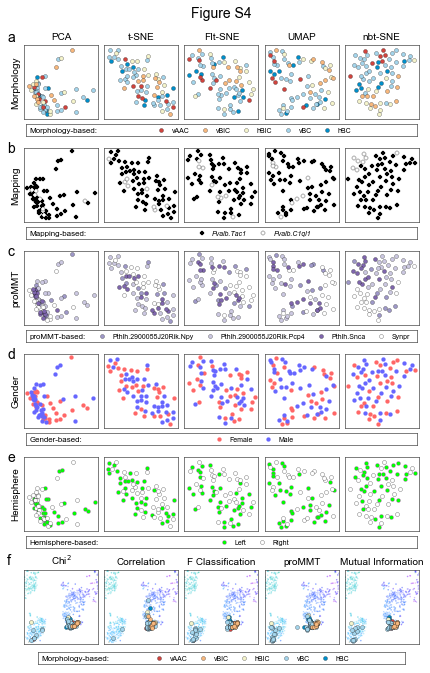

In [4]:
fig = do_embedding_plots(df_embedding_tpm, df_labels, 'Figure S4', df_color)
fig.savefig('Figures/Figure S4.pdf')
plt.show()